### TP 3 :

###### Group : Alexandre BOISTARD, William ROCHE, Ethan TRENTIN

In [146]:
import numpy
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import powerlaw
import statsmodels
from statsmodels import api
import tqdm
import Hawkes as hwk

First, let's implement a function that simulates one path of a Hawkes process with a generic decreasing kernel using the thinning algorithm.

For both the thinning and the branching algorithm, we will require the definition of a generic decreasing kernel. We will implement a single exponential kernel in the following function.

In [ ]:
def exponential_kernel(t, alpha, beta):
    """This function takes three arguments :
    - t : the time of the event
    - alpha
    - beta
    It returns the value of the exponential kernel at time t.
    """
    return alpha*numpy.exp(-beta*numpy.where(t>=0, t, numpy.inf)) # We want to choose t when t >= 0 and numpy.inf when t < 0 as we need to model an indicator function.

The implementation of the Hawkes process using the thinning algorithm uses the methodology described in the slide 11 of the lesson on Hawkes processes. 

In [157]:
def thinning_Hawkes_process(T, kernel_func, alpha = 0.6, beta = 0.8, lambda_0=1.2):
    """This function takes five arguments : 
    - T : the time horizon of the simulation
    - kernel_func : the kernel function (here we will use the exponential kernel in the notebook)
    - alpha : one parameter of the kernel function
    - beta : the other parameter of the kernel function
    - lambda_0 : the initial intensity of the process
    The last three are optional parameters as we will use the same values in the notebook.
    It returns a list of events of the Hawkes process."""
    # First we initialize the time, the lambda_star (the maximum of the intensity function) and the lambda_t. We also create an empty list of events.
    t = 0
    lambda_star = lambda_0
    lambda_t = lambda_0
    events = []
    while t < T:
        # We generate a new event candidate as following a uniform distribution and update the time t.
        U = numpy.random.uniform(0,1)
        t -= numpy.log(U)/lambda_star
        if t >= T:
            return events
        # Next, we do the thinning step by generating a uniform random variable D. 
        D = numpy.random.uniform(0,1)
        # We assign a value to lambda_t using the formula of the conditional intensity of a Hawkes process. We use the exponential kernel which means we can benefit from its memoryless property and only use the past event in the formula.
        if events :
            # To be sure that events is not empty.
            lambda_t = lambda_0 + kernel_func(t-events[-1], alpha, beta)
        # Now, we check is D is less than or equal to lambda_t/lambda_star. If it is, we add the event to the list of events and update lambda_star. Otherwise, we just update lambda_star.
        if D <= lambda_t/lambda_star:
            events.append(t)
            lambda_star = lambda_t+alpha 
        else:
            lambda_star = lambda_t
    return events

Next, we are going to write a function that simulates one path of a Hawkes process with a generic decreasing kernel (again we will use the exponential kernel) using the branching algorithm.

To do so, we need first to implement the simulation of a non-homogeneous poisson process. We will use the code from lab 2 implemented with a global thinning algorithm.

In [149]:
def simulate_nonhomogeneous_poisson(start, end, mu, mu_max=1):
    """This function generates a non-homogeneous poisson process. It has 4 parameters : 
    - start : the starting time of the process
    - end : the ending time of the process
    - mu : the intensity function of the process (it is a function of time)
    - mu_max : the maximum value of the intensity function (it is an optional parameter of the thinning algorithm).
    It returns a list of events of the non-homogeneous Poisson process."""
    events = []
    t = start
    # We generate realizations of a time-homogeneous Poisson process with parameter mu_max, and then we generate a uniform random variable that we compare to mu(t)/mu_max. We add to the events the set of points for which the uniform random variable is inferior or equal to mu(t)/mu_max. 
    while t < end:
        t += numpy.random.exponential(1 / mu_max)
        if t >= end:
            break

        if numpy.random.uniform(0, 1) <= mu(t) / mu_max:
            events.append(t)

    return events

In [151]:
def branching_Hawkes_process(T, kernel_func, alpha=0.6, beta=0.8, lambda_0=1.2):  
    """This function takes five arguments :
    - T : the time horizon of the Hawkes process
    - kernel_func : the kernel function used in the algorithm
    - alpha : one parameter of the kernel function (optional parameter)
    - beta : the other parameter of the kernel function (optional parameter)
    - lambda_0 : the intensity of the process (optional parameter).
    It returns a list of events of the Hawkes process."""
    t = 0
    poissons = []
    # We first generate a time-homogeneous Poisson process with intensity lambda_0 on [0,T].
    while t < T:
        t += numpy.random.exponential(1/lambda_0)
        if t<T:
            poissons.append(t)
    new_pt = True
    Ti1 = poissons.copy()
    # Now, for each event of the Poisson process, we generate a non-homogeneous Poisson process with intensity kernel_func(t-pt) with pt the time of the event of the Poisson process. We repeat this operation for the times of the newly generated process, and so on until there is no new point generated in [0,T], hence the usage of the new_pt variable.
    while new_pt:
        new_pt = False
        Ti2 = []
        for pt in Ti1:
            Ti3 = simulate_nonhomogeneous_poisson(pt,T,lambda t:kernel_func(t-pt, alpha, beta),1)
            if Ti3:
                new_pt = True
                Ti2.extend(Ti3)
        Ti1 = Ti2.copy()
        poissons.extend(Ti2)
    # We returned the ordered set of all the points that we generated to get a Hawkes Process. 
    return numpy.sort(poissons)

Now, to visualize the results of our algorithms, we are going to plot the Hawkes processes resulting from both the thinning and the branching algorithms.

In [181]:
def plot_Hawkes(events, T, algorithm, kernel_func, alpha = 0.6, beta = 0.8, lambda_0=1.2):
    """This function takes seven arguments : 
    - events : the list of events of the Hawkes process we want to visualize
    - T : the time horizon of the process
    - algorithm : the algorithm used to generate the process (thinning or branching)
    - kernel_func : the kernel function used in the algorithm
    - alpha : one parameter of the kernel function (optional parameter)
    - beta : the other parameter of the kernel function (optional parameter)
    - lambda_0 : the intensity of the process (optional parameter).
    It plots the simulation of one path of the generated Hawkes process."""
    interval = numpy.linspace(0,T,1000)
    values = numpy.zeros(1000)+lambda_0
    for event in events:
        values += alpha*numpy.exp(-beta*numpy.where(interval-event>0, interval-event, numpy.inf))
    peaks, _ = scipy.signal.find_peaks(values)
    local_maxima = values[peaks]
    max_intensity = numpy.zeros(1000)+lambda_0
    current_max = lambda_0
    for i,peak in enumerate(peaks):
        max_intensity[peak:] = local_maxima[i]    
    plt.figure(figsize=(10,6))
    plt.scatter(events, numpy.ones(len(events)), color = 'blue', marker = '^', facecolors='none', label='Events')
    plt.plot(interval, values, color='red', label='Intensity $\lambda$')
    plt.plot(interval, max_intensity, color='green', linestyle='--', label='Intensity maximum $\lambda^*$')
    plt.title(f"Simulation of one path of a Hawkes process with the {algorithm} algorithm and the {kernel_func} kernel")
    plt.xlabel('Time')
    plt.ylabel('Intensity')
    plt.grid()
    plt.legend()
    plt.show()

In [ ]:
# We choose a value of the time horizon parameter. 
T = 10

Let's check that our thinning and branching algorithms correctly return the times of the Hawkes process generated. 

In [ ]:
test_Hawkes_thinning, test_Hawkes_branching= thinning_Hawkes_process(T, exponential_kernel), branching_Hawkes_process(T,exponential_kernel)
test_Hawkes_thinning, test_Hawkes_branching

([0.5479048215712177,
  0.630388405435549,
  1.6182212952151307,
  2.6178253390611914,
  2.805637737620084,
  3.506588546288656,
  3.7547554184832532,
  5.2996180321754816,
  5.709718263268362,
  6.1038676900989755,
  7.195396506864804,
  7.52893494581606,
  7.973771093129046,
  9.076340331298157],
 array([0.97328967, 1.06950611, 1.39170944, 2.00343356, 2.12002784,
        2.21741814, 2.35571977, 2.53371918, 3.04427885, 3.12374355,
        3.19011258, 3.21438757, 3.42843611, 3.55648153, 3.93154372,
        3.99041777, 4.04795751, 4.24954752, 4.26361576, 4.6272624 ,
        4.79538873, 5.01881669, 5.09682293, 5.17588273, 5.29236901,
        5.42285499, 5.48224603, 5.48464742, 5.50412151, 5.63904973,
        5.79403201, 5.98565639, 6.0770472 , 6.11173839, 6.23447244,
        6.27873303, 6.4975388 , 6.74514676, 6.96879296, 6.96939388,
        7.44324276, 7.4718712 , 7.63147642, 7.64934575, 7.65001141,
        7.89268915, 7.97550151, 8.30780829, 8.51747247, 8.58462682,
        8.64700502, 

And now, we will visualize the Hawkes process created thanks to the thinning and branching algorithm. 

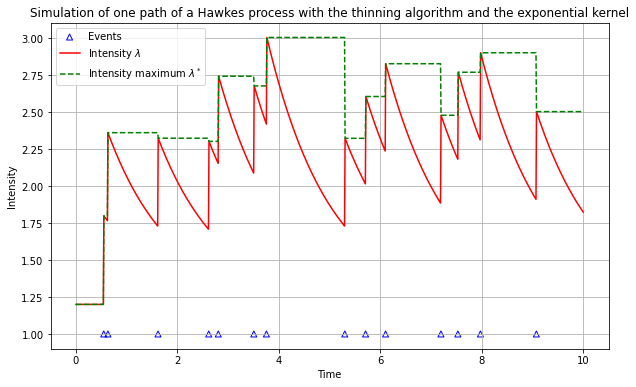

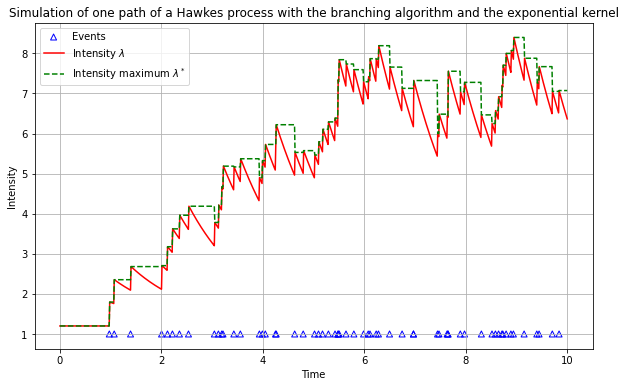

In [182]:
plot_Hawkes(test_Hawkes_thinning, T, "thinning", "exponential")
plot_Hawkes(test_Hawkes_branching, T, "branching", "exponential")

Comments : These plots display 

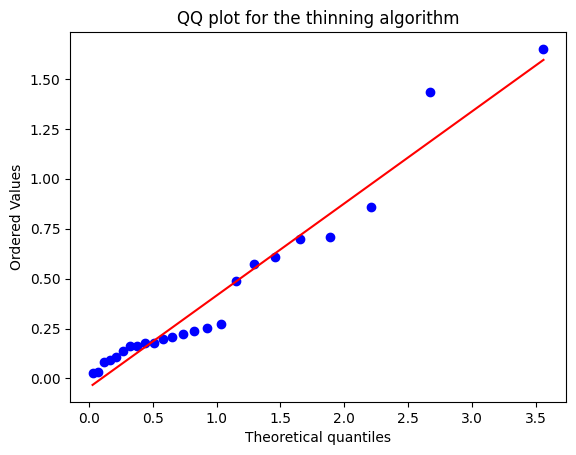

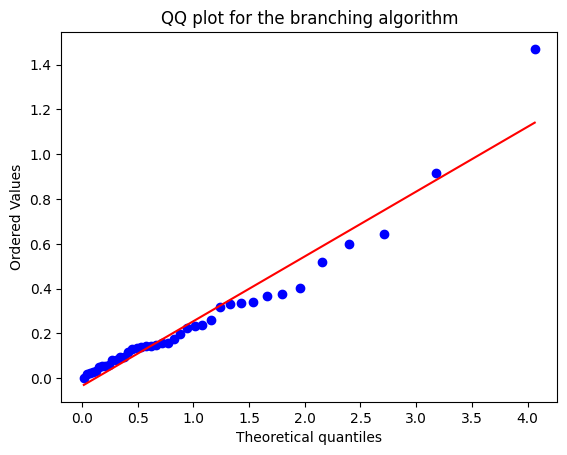

In [68]:
def qq_plot_hawkes(events, title="QQ plot for the Hawkes process"):
    inter_event_times = numpy.diff(events)
    scipy.stats.probplot(inter_event_times, dist="expon", plot=plt)
    plt.title(title)
    plt.show()

qq_plot_hawkes(test_Hawkes_thinning, title="QQ plot for the thinning algorithm")
qq_plot_hawkes(test_Hawkes_branching, title="QQ plot for the branching algorithm")

Question 1 : **Properties of Hawkes MLE estimates**. Check that MLE estimators computed with the Hawkes library on samples simulated by our simulators exhibit expected statistical properties.

In [69]:
def MLE_parameters_estimations(algorithm, kernel_func, kernel_name, T):
    if algorithm == "thinning":
        path = thinning_Hawkes_process(T, kernel_func)
    elif algorithm == "branching":
        path = branching_Hawkes_process(T, kernel_func)
    model = hwk.estimator()
    model.set_kernel(kernel_name)
    model.set_baseline('const')
    model.fit(path, [0,T])
    estimations = model.parameter
    return estimations

In [70]:
MLE_parameters_estimations("thinning", exponential_kernel, "exp", 10)

{'mu': np.float64(1.2566500820853597),
 'alpha': np.float64(4389.024272378765),
 'beta': np.float64(1.6680991796646016e-06)}

In [71]:
def plot_consistency_horizon(true_params, T_list, algorithm, kernel_func, kernel_name):
    estimations = {t: MLE_parameters_estimations(algorithm, kernel_func, kernel_name, t) for t in T_list}
    estimations_final = {}
    for n in estimations.keys():
        means = {}
        for param in ['mu','alpha', 'beta']:
            inter = estimations[n][param]
            if param == 'mu':
                param = 'lambda_0'
            means[param] = inter
        estimations_final[n] = means
    fig, ax = plt.subplots(3,1, figsize=(20,15))
    colors = ['red', 'blue', 'green']
    for i, param in enumerate(true_params.keys()):
        ax[i].plot(T_list, [estimations_final[j][param] for j in estimations_final.keys()], label=f'Estimated {param}', color =colors[i], marker='o')
        ax[i].axhline(true_params[param], color=colors[i], linestyle='--',label=f'True {param}')
        ax[i].set_title(f'Consistency of the {param} of the MLE Estimate for the Hawkes process simulated by {algorithm} with a {kernel_name} kernel')
        ax[i].set_xlabel("Time horizon")
        ax[i].set_ylabel(f'Estimated {param}')
        ax[i].legend()
    plt.show()

In [72]:
true_parameters = {'lambda_0': 1.2,'alpha': 0.6, 'beta': 0.8}
T_list = numpy.arange(1, 102, 10)

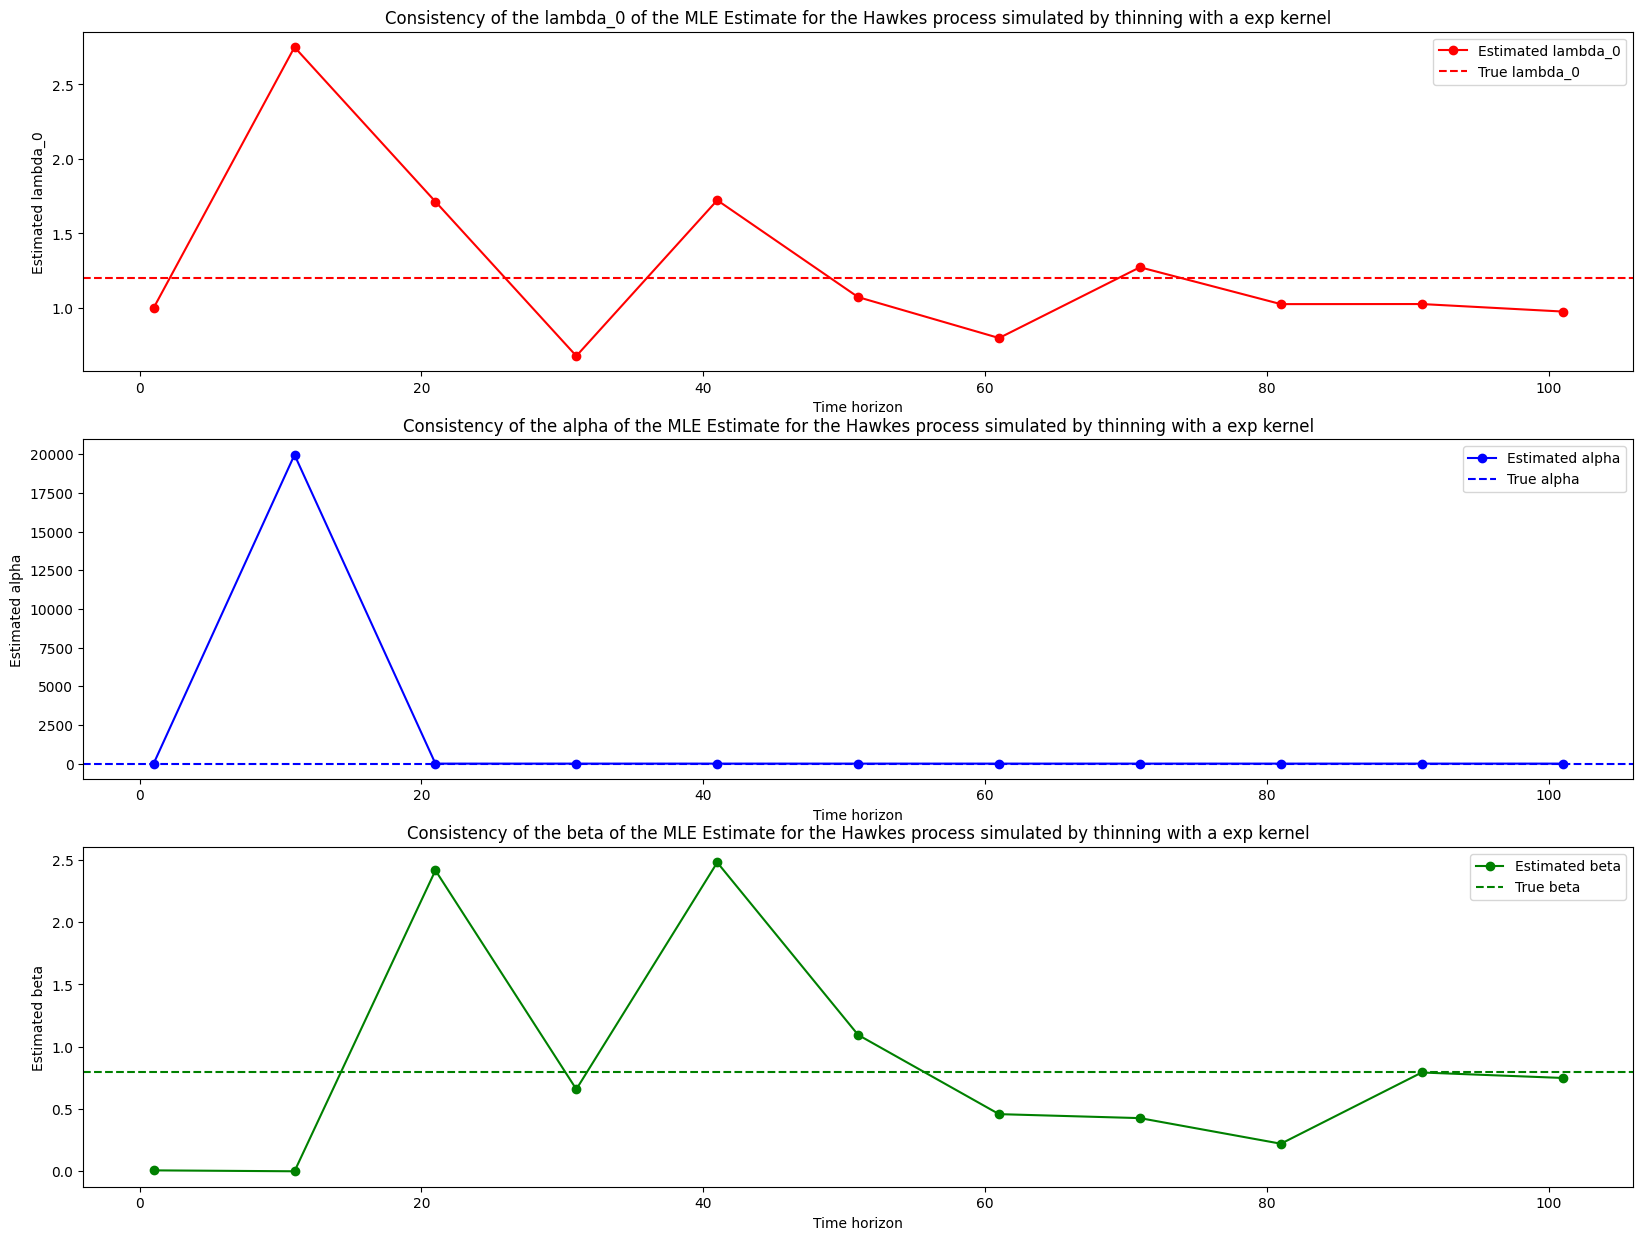

In [73]:
plot_consistency_horizon(true_parameters, T_list, "thinning", exponential_kernel, "exp")

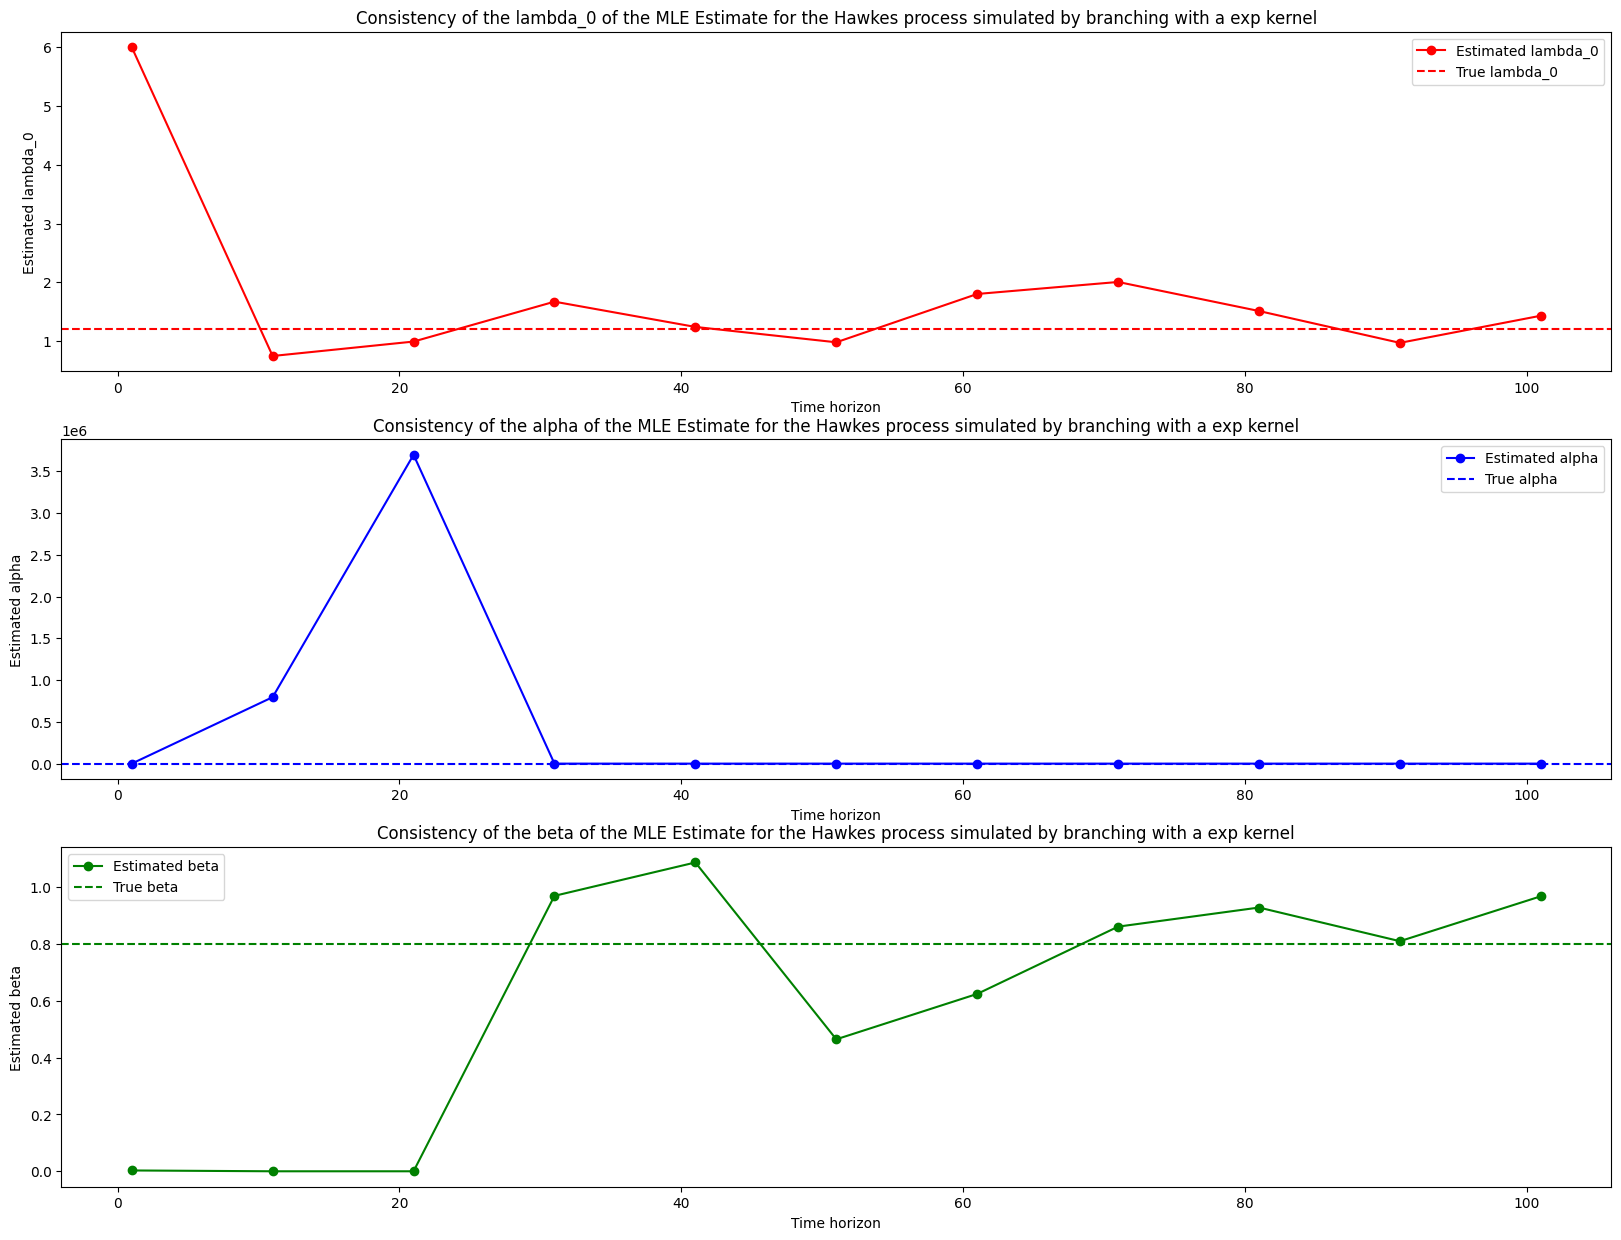

In [74]:
plot_consistency_horizon(true_parameters, T_list, "branching", exponential_kernel, "exp")

But it is better to simulate multiple paths in order to reduce variability and improve statistical stability. Let's update the previous functions.

In [75]:
def plot_consistency_horizon_multiple_paths(true_params, T_list, num_paths, algorithm, kernel_func, kernel_name):
    estimations = {t: [MLE_parameters_estimations(algorithm, kernel_func, kernel_name, t) for _ in range(num_paths)] for t in T_list}
    mean_params = {t: {} for t in T_list}
    for t in T_list:
        # Initialize lists to store parameter values for each path
        lambda_values = []
        alpha_values = []
        beta_values = []

        for estimation in estimations[t]:
            lambda_values.append(estimation['mu'])
            alpha_values.append(estimation['alpha'])
            beta_values.append(estimation['beta'])

        # Compute the mean for each parameter
        mean_params[t]['lambda_0'] = numpy.mean(lambda_values)
        mean_params[t]['alpha'] = numpy.mean(alpha_values)
        mean_params[t]['beta'] = numpy.mean(beta_values)
    fig, ax = plt.subplots(3,1, figsize=(20,15))
    colors = ['red', 'blue', 'green']
    for i, param in enumerate(true_params.keys()):
        ax[i].plot(T_list, [mean_params[j][param] for j in mean_params.keys()], label=f'Estimated {param}', color =colors[i], marker='o')
        ax[i].axhline(true_params[param], color=colors[i], linestyle='--',label=f'True {param}')
        ax[i].set_title(f'Consistency of the {param} of the MLE Estimate for the Hawkes process simulated by {algorithm} with a {kernel_name} kernel')
        ax[i].set_xlabel("Time horizon")
        ax[i].set_ylabel(f'Estimated {param}')
        ax[i].legend()
    plt.show()

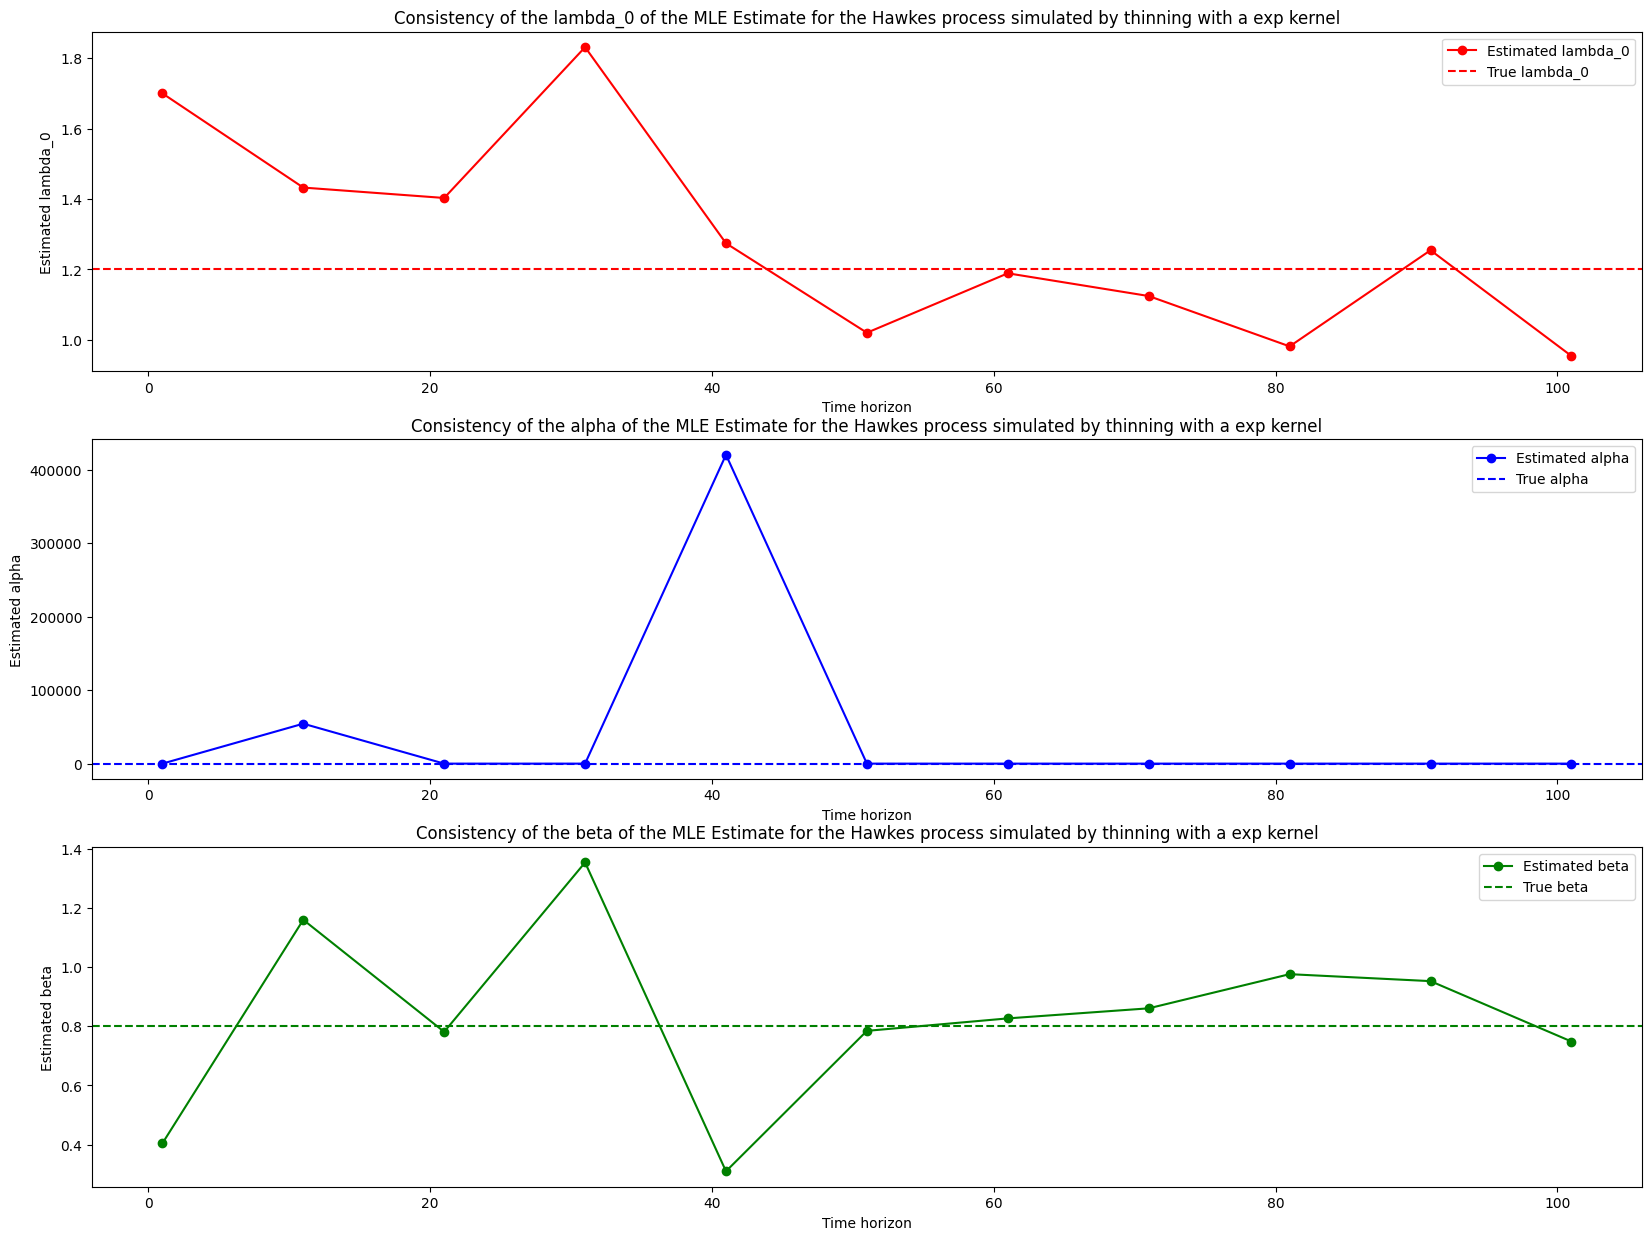

In [76]:
num_paths = 10 # A augmenter pour le rendu final
plot_consistency_horizon_multiple_paths(true_parameters, T_list, num_paths, "thinning", exponential_kernel, "exp")

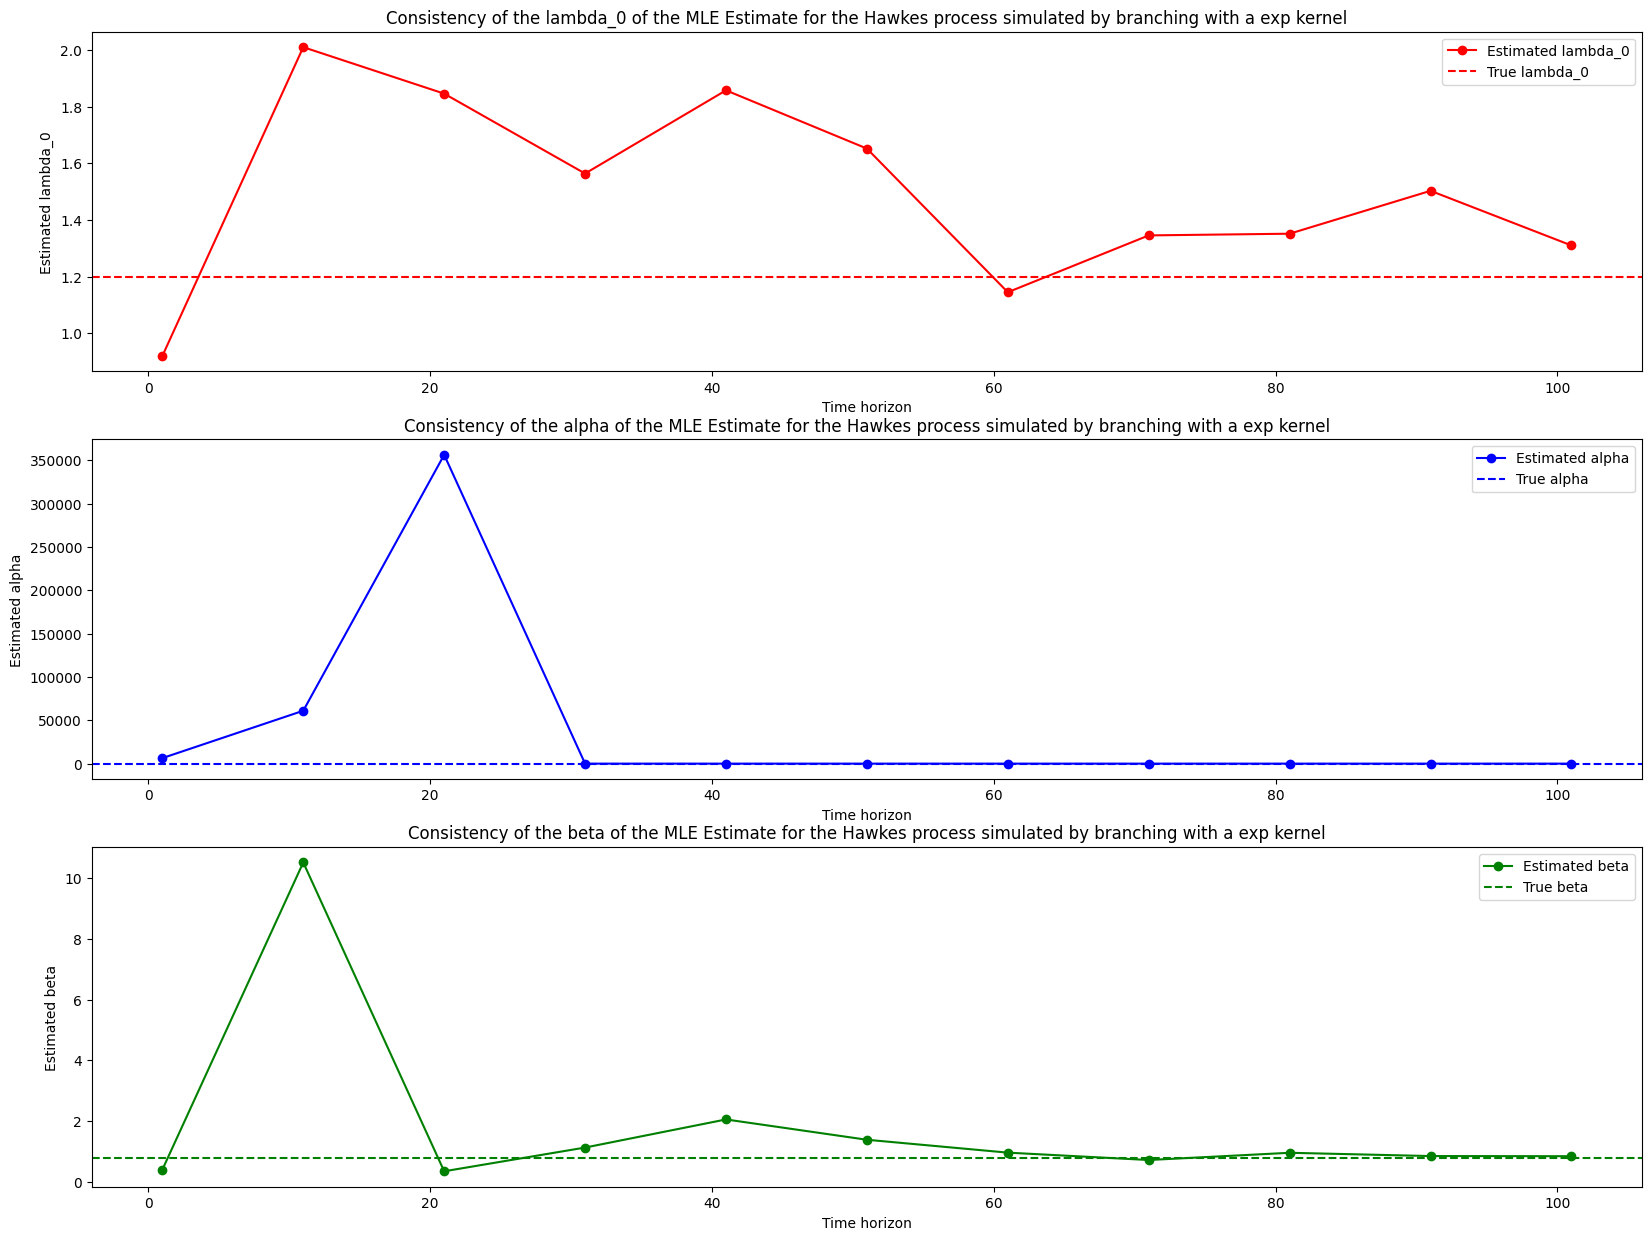

In [77]:
plot_consistency_horizon_multiple_paths(true_parameters, T_list, num_paths, "branching", exponential_kernel, "exp")

In [78]:
def plot_asymptotic_normality(true_params, T_list, num_paths, algorithm, kernel_func, kernel_name):
    estimations = {t: [MLE_parameters_estimations(algorithm, kernel_func, kernel_name, t) for _ in range(num_paths)] for t in T_list}
    for t in estimations:
      for i, estimation in enumerate(estimations[t]):
          ordered_estimation = {
              'lambda_0': estimation.pop('mu'),
              'alpha': estimation['alpha'],
              'beta': estimation['beta']
          }
          estimations[t][i] = ordered_estimation
    for t, estimates in estimations.items():
        plt.figure(figsize=(10, 6))
        colors = ["red", "blue", "green"]
        for i, param in enumerate(true_params.keys()):
            plt.subplot(len(true_params), 1, i+1)
            param_list = [est[param] for est in estimates]
            plt.hist(param_list, bins=20, alpha=0.6, color=colors[i%3], label='MLE Estimates')
            mean = numpy.mean(param_list)
            std = numpy.std(param_list)
            x = numpy.linspace(min(param_list), max(param_list), 1000)
            plt.plot(x, scipy.stats.norm.pdf(x, mean, std), label='Normal Distribution')
            plt.title(f'Distribution of {param} Estimates (t={t:.4f})')
            plt.xlabel(param)
            plt.ylabel('Frequency')
            plt.legend()
        plt.tight_layout()
        plt.show()

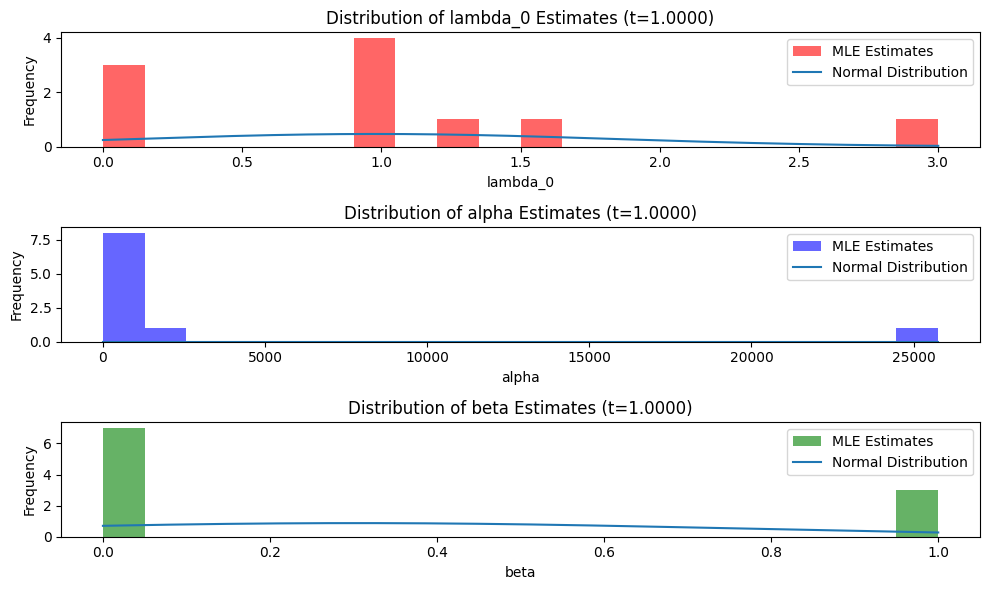

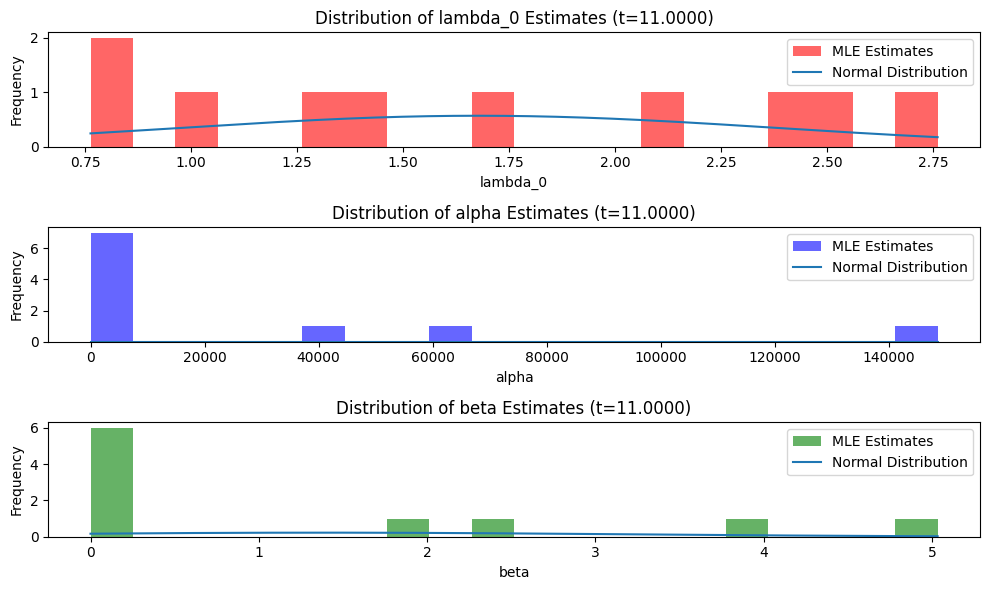

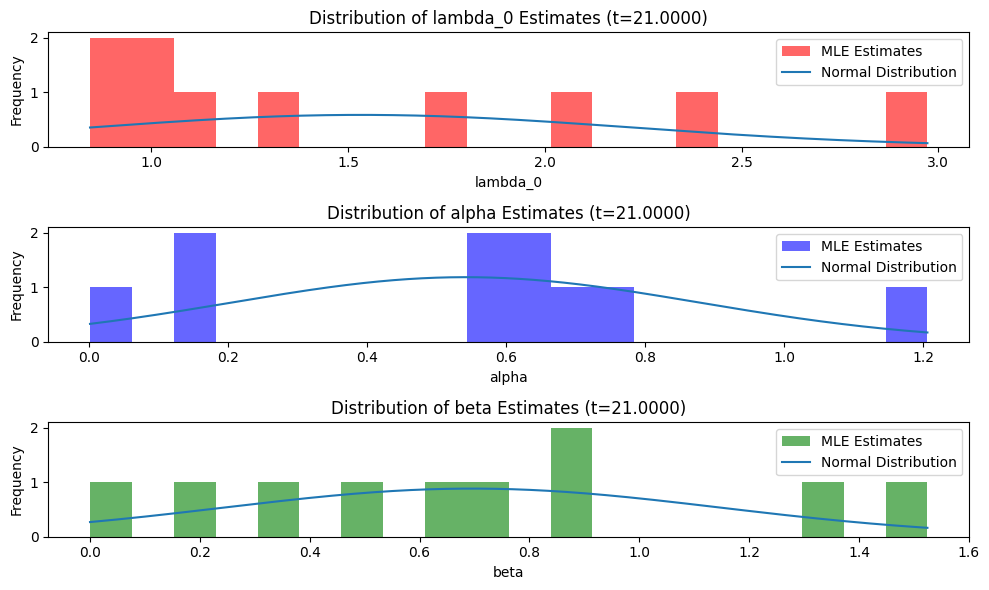

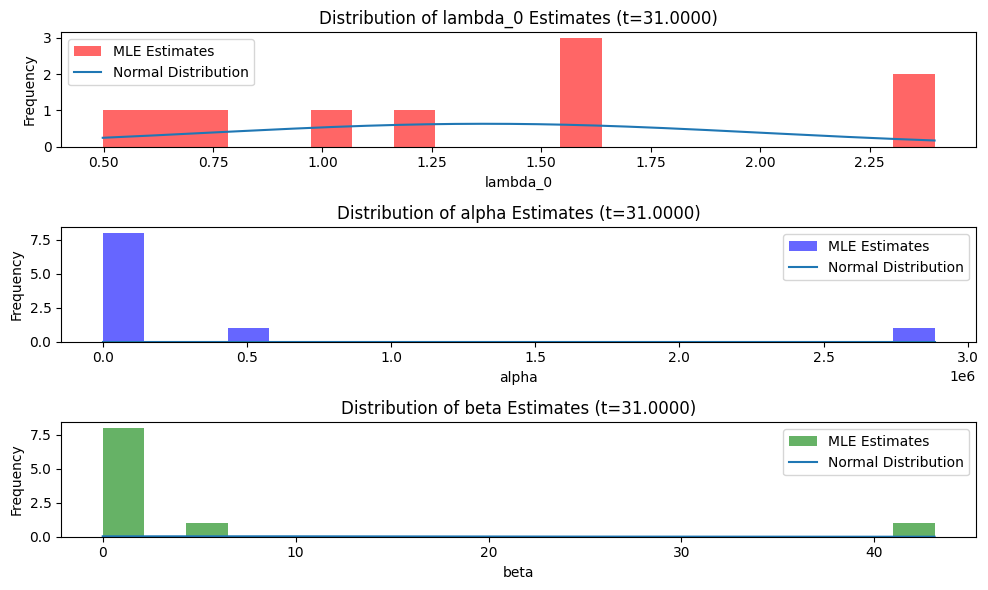

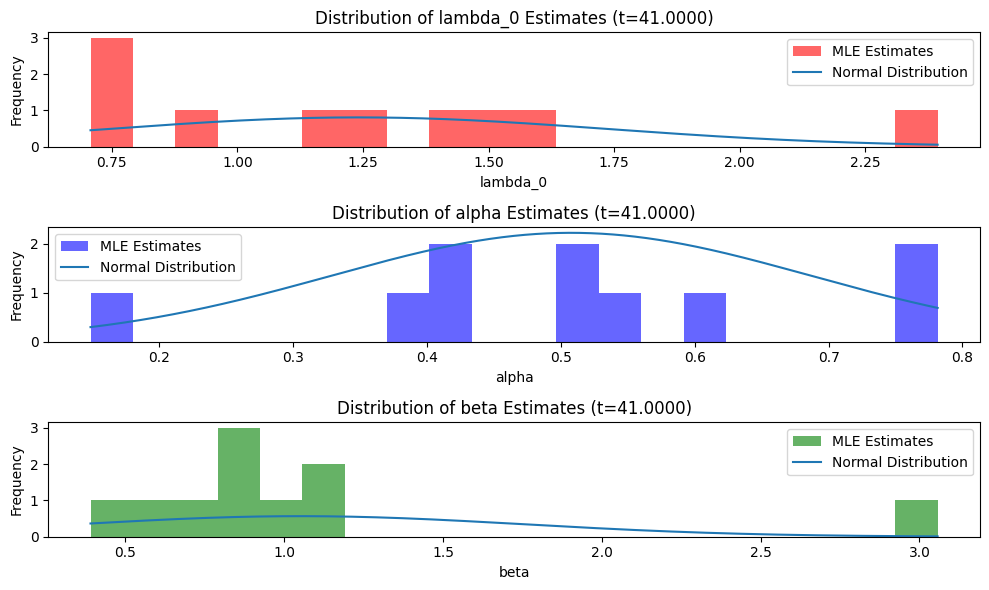

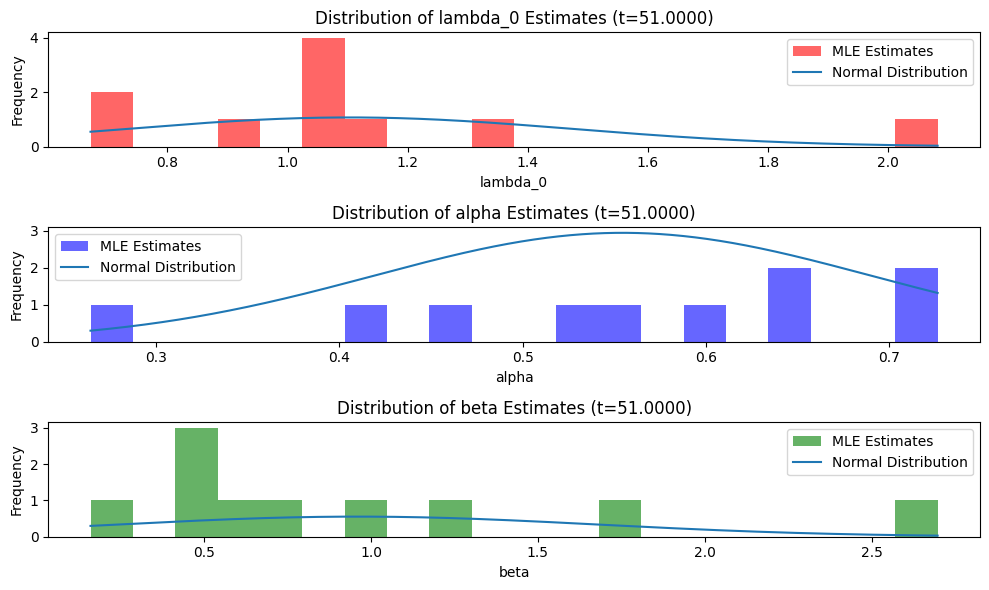

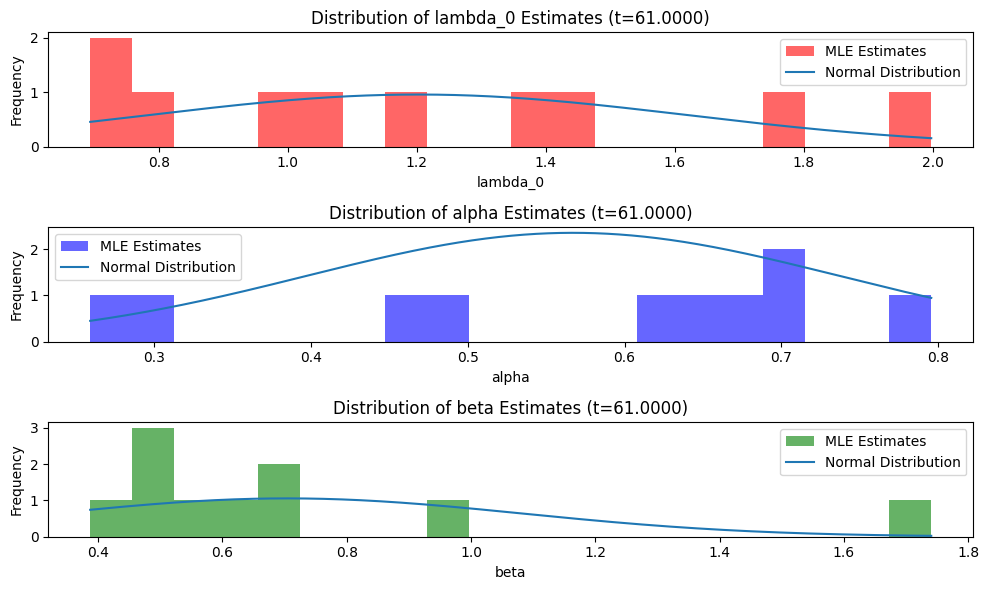

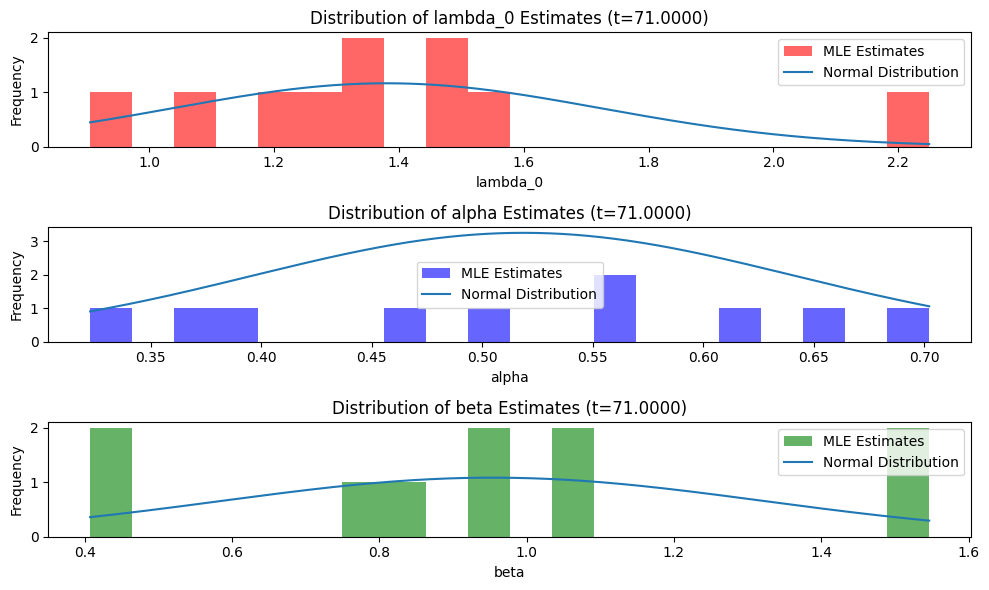

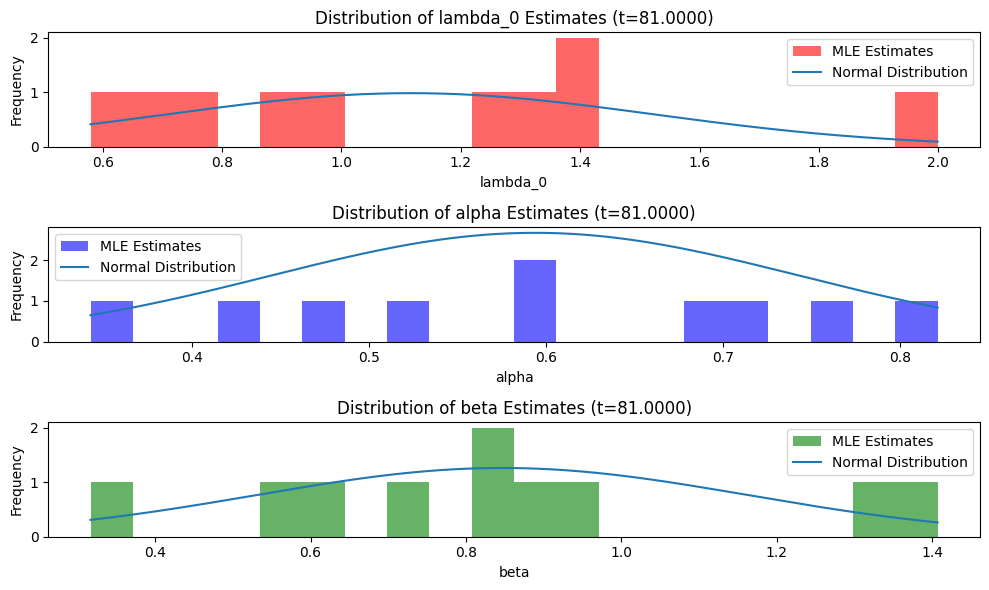

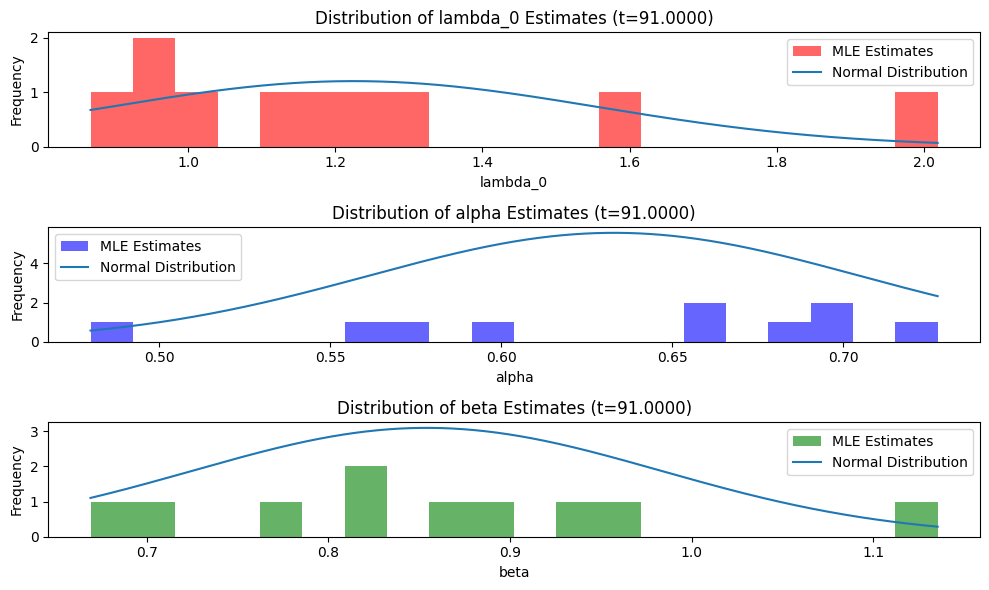

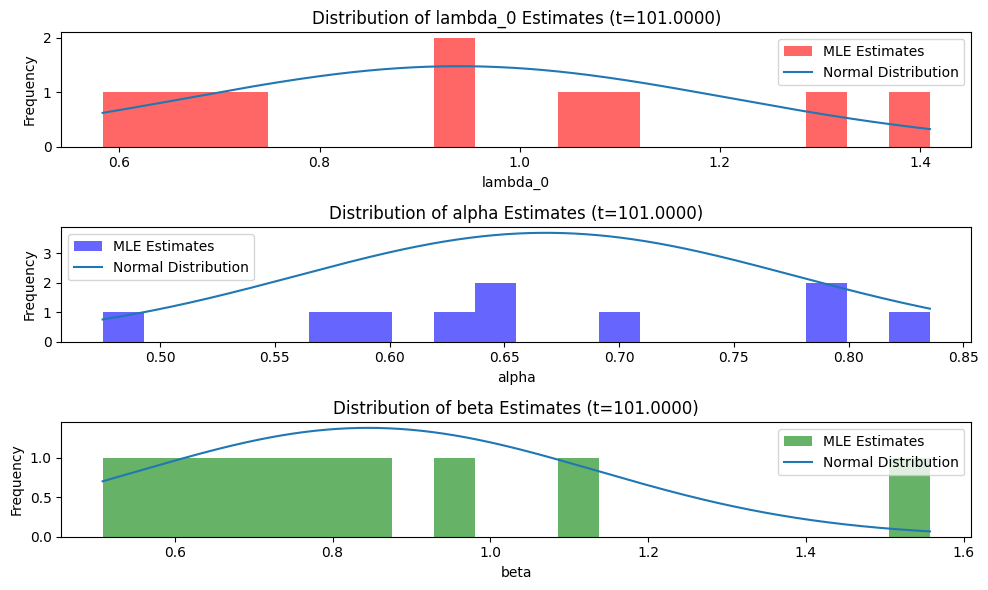

In [79]:
# increase the number of paths and change T_list for the final
plot_asymptotic_normality(true_parameters, T_list, 10, "thinning", exponential_kernel, "exp")

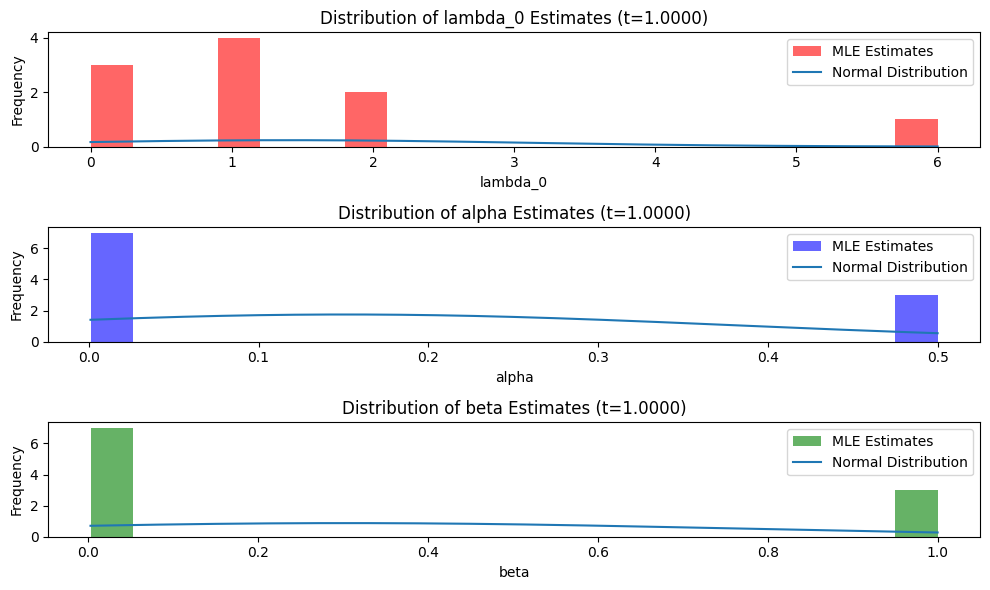

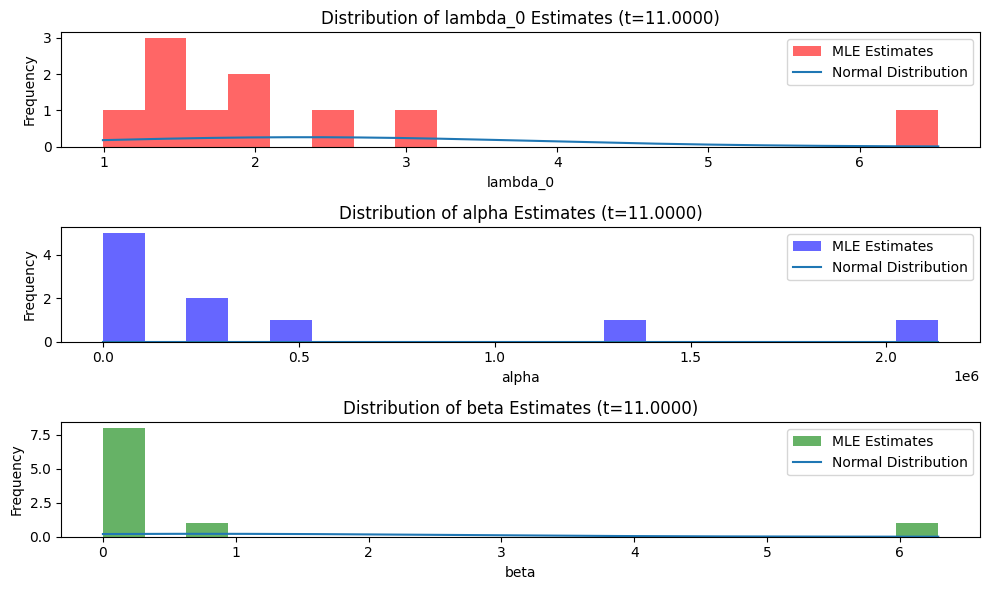

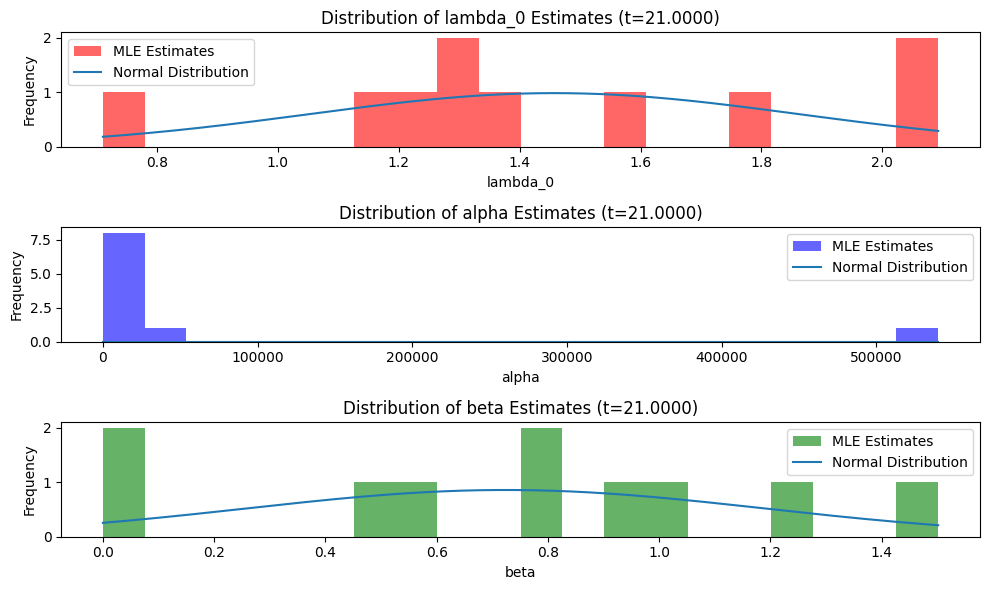

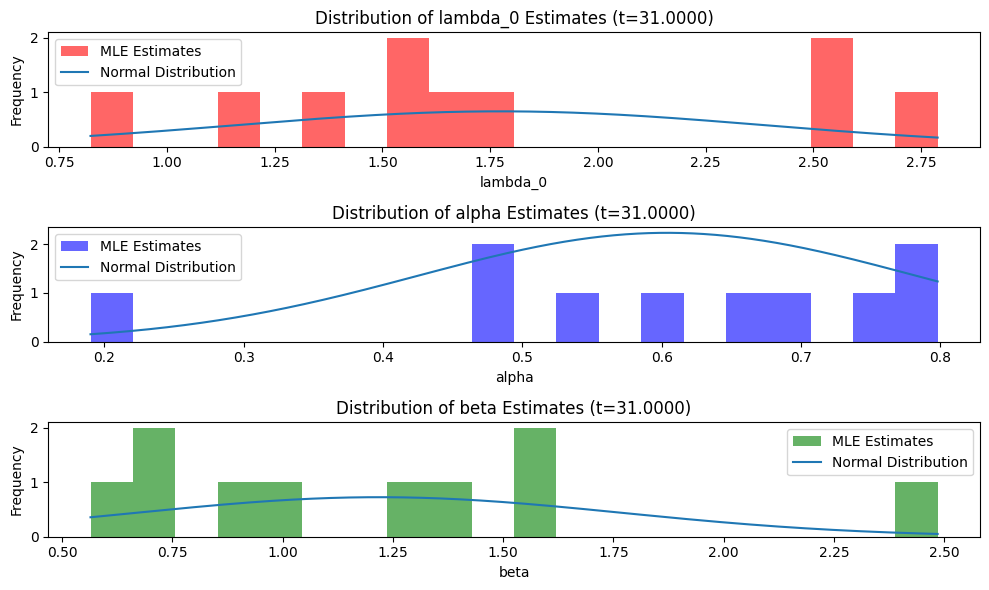

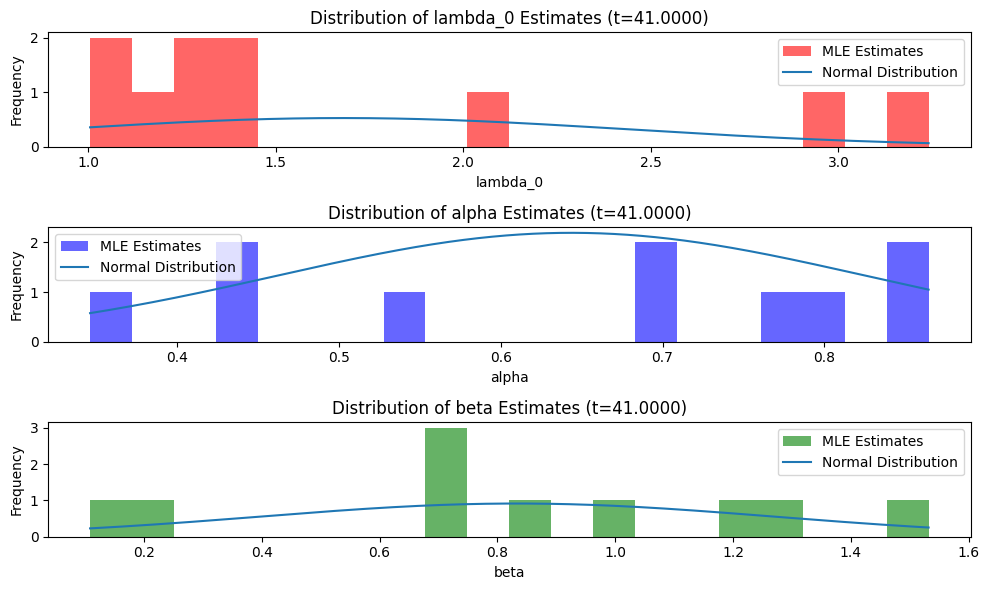

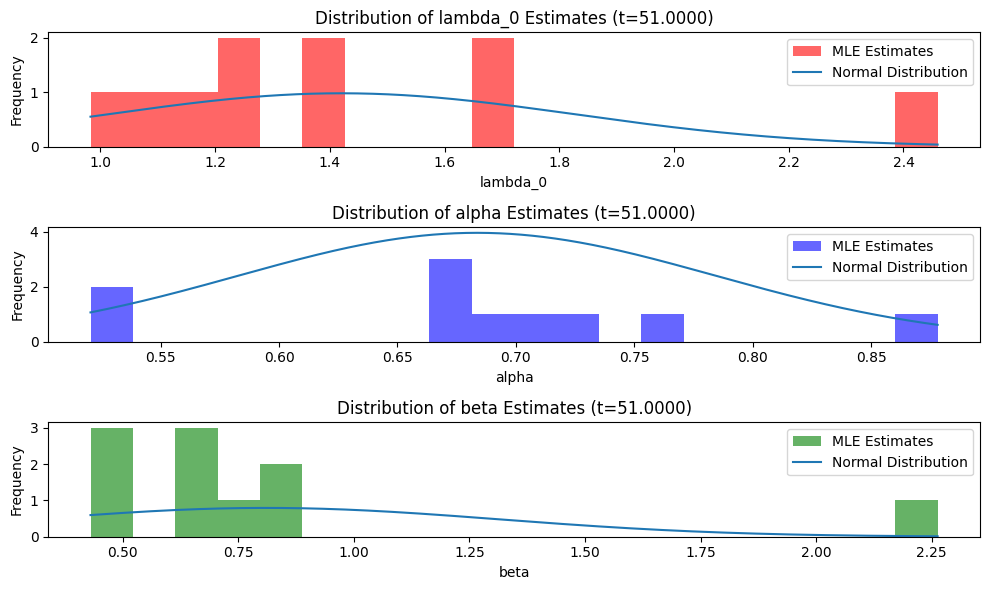

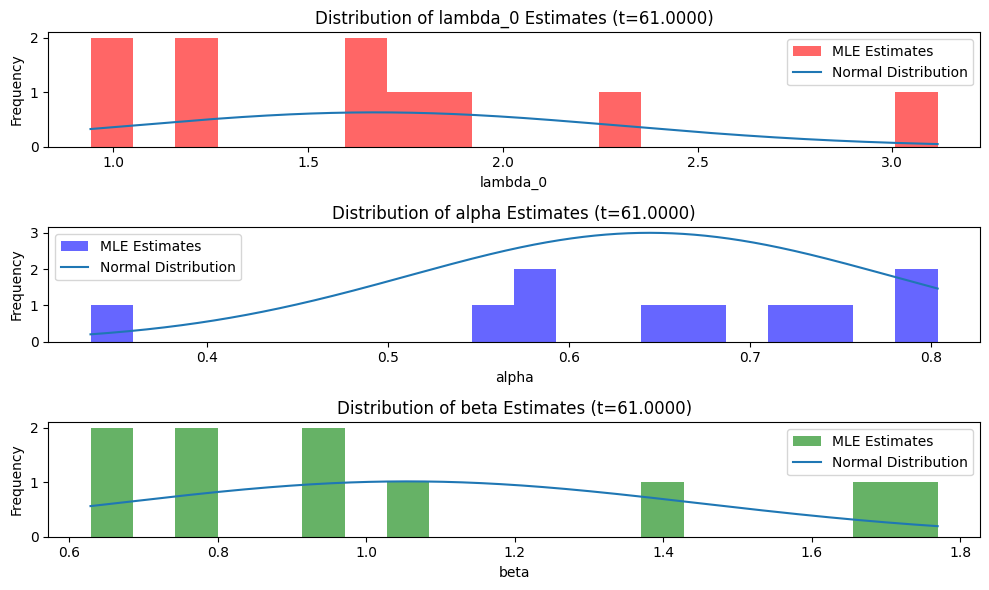

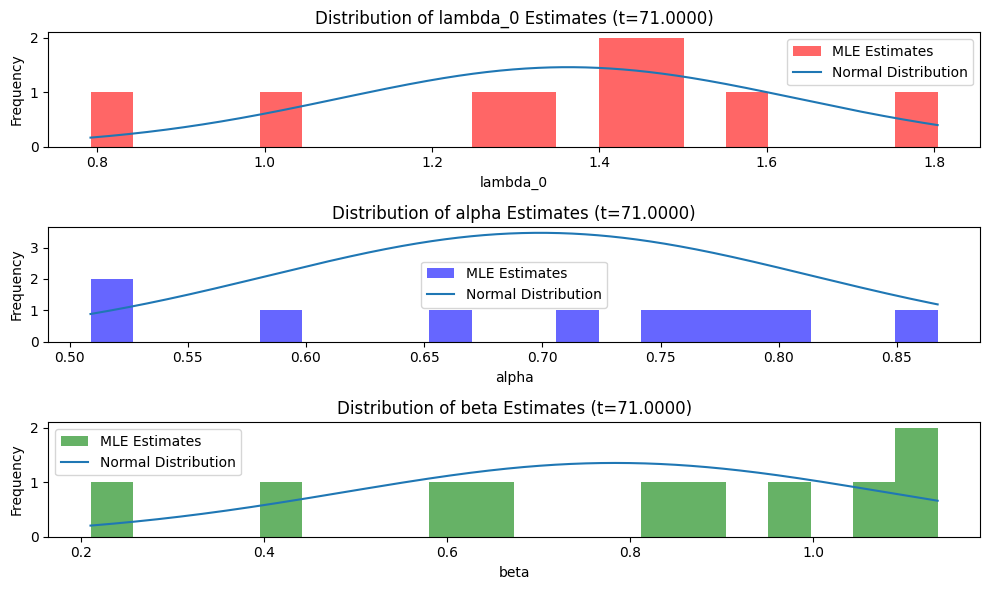

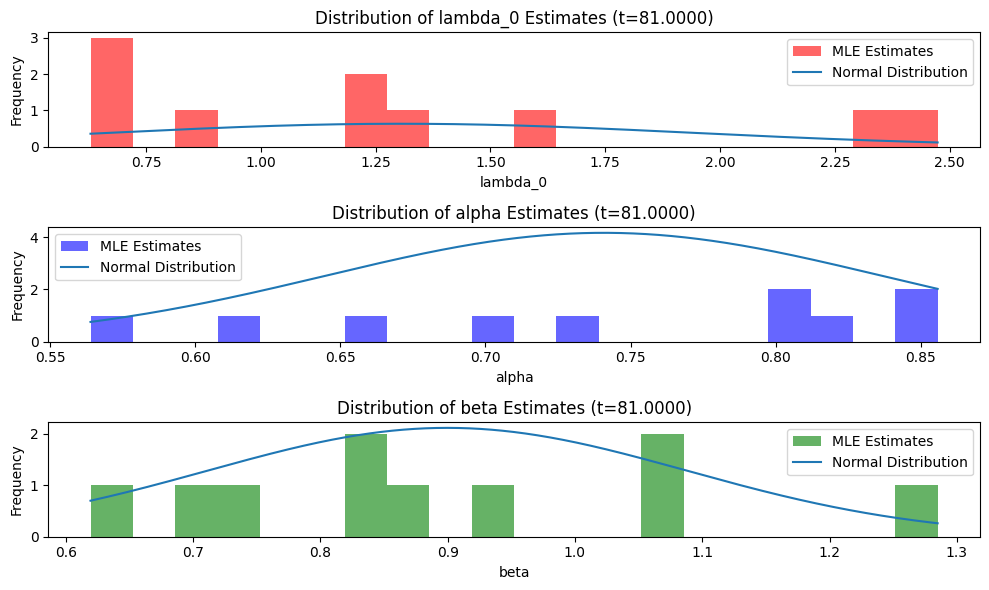

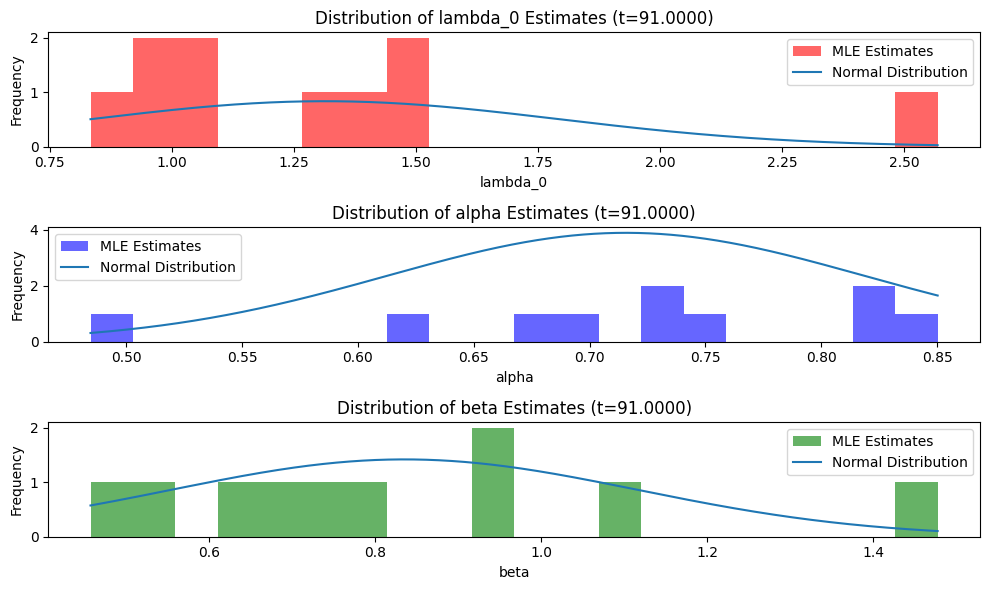

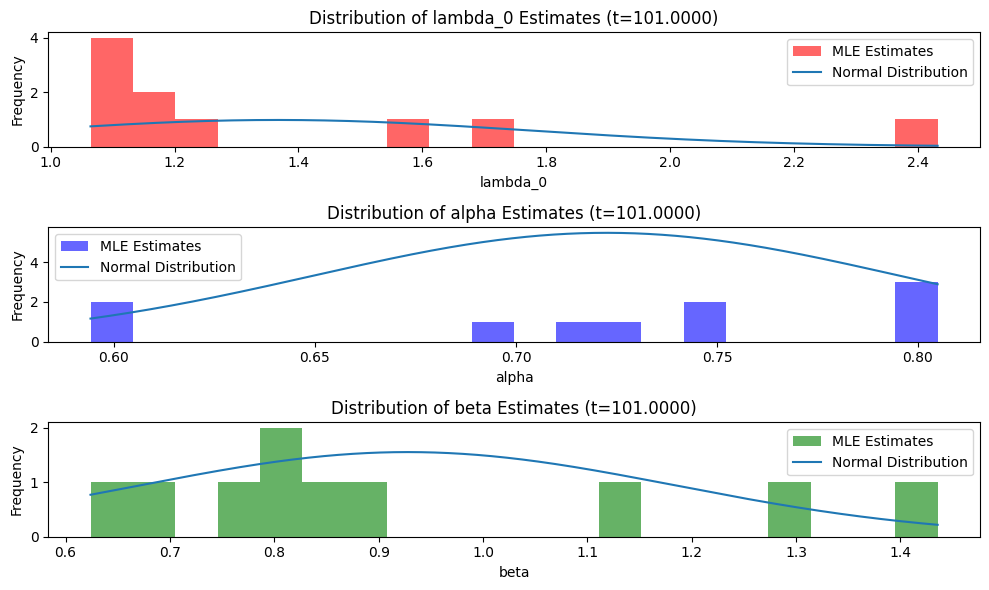

In [80]:
plot_asymptotic_normality(true_parameters, T_list, 10, "branching", exponential_kernel, "exp")

Est-ce qu'on rajoute asymptotically efficient ?

Question 2 : **Computational cost of Hawkes simulators.** Compare for an exponential kernel the
 computational cost of your thinning algorithm, your branching algorithm, and the
 simulation of the Hawkes library. Estimate the complexity of these algorithm w.r.t. the
 horizon. Explain.

In [81]:
def library_simulation_exponential(T, true_params):
    model = hwk.simulator()
    model.set_kernel("exp")
    model.set_baseline("const")
    model.set_parameter(true_params)
    events = model.simulate([0,T])
    return events

In [82]:
def computational_cost_multiple_paths(kernel_func, T, num_iterations, true_params):
    true_para = {}
    for param in true_params.keys():
        inter = true_params[param]
        if param == 'lambda_0':
            param = 'mu'
        true_para[param] = inter

    start_time = numpy.datetime64('now')
    for _ in range(num_iterations):
        thinning_Hawkes_process(T, kernel_func)
    end_time = numpy.datetime64('now')
    time_thinning = (end_time - start_time) / numpy.timedelta64(1, 'ms') / num_iterations

    start_time = numpy.datetime64('now')
    for _ in range(num_iterations):
        branching_Hawkes_process(T, kernel_func)
    end_time = numpy.datetime64('now')
    time_branching = (end_time - start_time) / numpy.timedelta64(1, 'ms') / num_iterations

    start_time = numpy.datetime64('now')
    for _ in range(num_iterations):
        library_simulation_exponential(T, true_para)
    end_time = numpy.datetime64('now')
    time_library = (end_time - start_time) / numpy.timedelta64(1, 'ms') / num_iterations

    return time_thinning, time_branching, time_library

In [83]:
time_thinning, time_branching, time_library = computational_cost_multiple_paths(exponential_kernel, 10, 10000, true_parameters)
print("### Computational Cost ###")
print(f"Thinning algorithm : {time_thinning:.3f} microseconds per iteration")
print(f"Branching algorithm : {time_branching:.3f} microseconds per iteration")
print(f"Hawkes library : {time_library:.3f} microseconds per iteration")

### Computational Cost ###
Thinning algorithm : 3.000000 microseconds per iteration
Branching algorithm : 1.700000 microseconds per iteration
Hawkes library : 0.900000 microseconds per iteration


Comments :

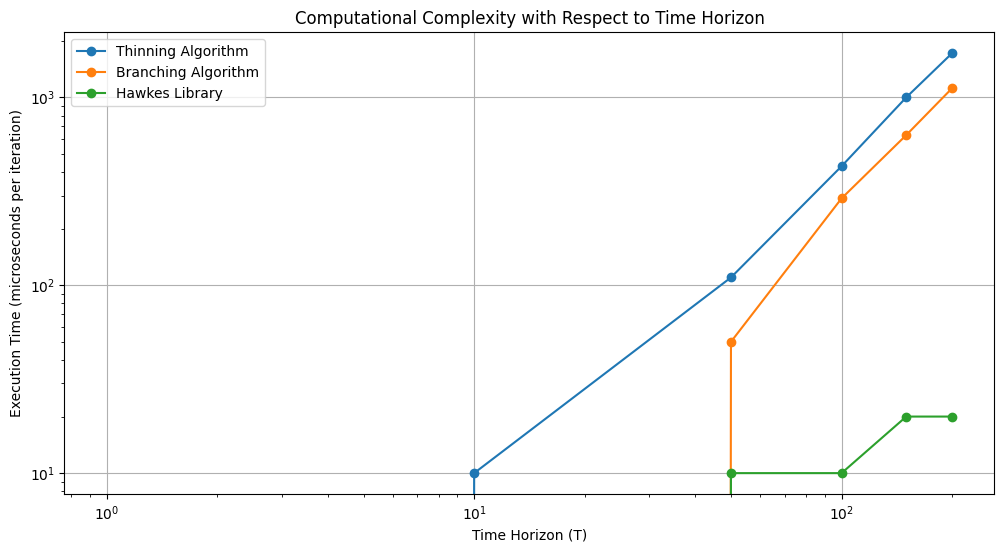

In [92]:
def estimate_complexity(kernel_func, T_values, num_iterations, true_params):
    thinning_times = []
    branching_times = []
    library_times = []

    for T in T_values:
        time_thinning, time_branching, time_library = computational_cost_multiple_paths(kernel_func, T, num_iterations, true_params)
        thinning_times.append(time_thinning)
        branching_times.append(time_branching)
        library_times.append(time_library)

    return thinning_times, branching_times, library_times

# Example usage
T_values = [1, 10, 50, 100, 150, 200]  # Define a range of T values

thinning_times, branching_times, library_times = estimate_complexity(exponential_kernel, T_values, 100, true_parameters)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(T_values, thinning_times, label='Thinning Algorithm', marker='o')
plt.plot(T_values, branching_times, label='Branching Algorithm', marker='o')
plt.plot(T_values, library_times, label='Hawkes Library', marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time Horizon (T)')
plt.ylabel('Execution Time (microseconds per iteration)')
plt.title('Computational Complexity with Respect to Time Horizon')
plt.legend()
plt.grid(True)
plt.show()

On rajoute un plot ou on améliore l'actuel pour essayer d'avoir une meilleure idée de la complexité : mettre en échelle log par exemple

Question 3 :

In [84]:
#### playground ####

First, let's define a function to simulate multiple paths of a Hawkes process, with the name of the algorithm as a variable so that the function adapts to both thinning and branching algorithm.

In [85]:
def mulitple_hawkes_paths(num_paths, T, kernel_func, algorithm, alpha = 0.6, beta = 0.8, lambda_0=1.2):
    paths = []
    for _ in range(num_paths):
        if algorithm == "thinning":
            event = thinning_Hawkes_process(T, kernel_func, alpha, beta, lambda_0)
        elif algorithm == "branching":
            event = branching_Hawkes_process(kernel_func, T, alpha, beta, lambda_0)
        paths.append(event)
    return paths

Now, we define a function that computes the estimation of the parameters using the Maximum-likelihood estimator $\hat{\theta}_T=(\hat{\lambda_0}, \hat{\alpha_j},\hat{\beta_j})$

In [86]:
def MLE_parameters_estimations(paths, kernel_func):
    estimations = []
    for event in paths:
        model = hwk.estimator()
        model.set_kernel(kernel_func)
        model.set_baseline('const')
        model.fit(event, [0,10])
        estimations.append(model.parameter)
    return estimations

In [87]:
def plot_consistency(true_params, num_paths, algorithm, kernel_func):
    estimations = {n: MLE_parameters_estimations(mulitple_hawkes_paths(n, 10, exponential_kernel, algorithm), kernel_func) for n in num_paths}
    estimations_means = {}
    for n in estimations.keys():
        means = {}
        for param in ['mu','alpha', 'beta']:
            inter = numpy.mean([estimations[n][i][param] for i in range(len(estimations[n]))])
            if param == 'mu':
                param = 'lambda_0'
            means[param] = inter
        estimations_means[n] = means
    fig, ax = plt.subplots(3,1, figsize=(20,15))
    colors = ['red', 'blue', 'green']
    for i, param in enumerate(true_params.keys()):
        ax[i].plot(num_paths, [estimations_means[j][param] for j in estimations_means.keys()], label=f'Estimated {param}', color =colors[i], marker='o')
        ax[i].axhline(true_params[param], color=colors[i], linestyle='--',label=f'True {param}')
        ax[i].set_title(f'Consistency of the {param} of the MLE Estimate for the Hawkes process simulated by {algorithm} with a {kernel_func} kernel')
        ax[i].set_xlabel('Number of paths')
        ax[i].set_ylabel(f'Estimated {param}')
        ax[i].legend()
    plt.show()

In [88]:
true_parameters = {'lambda_0': 1.2,'alpha': 0.6, 'beta': 0.8}
num_paths = numpy.arange(10, 10011, 100)

In [89]:
plot_consistency(true_parameters, num_paths, "thinning",  "exp")

KeyboardInterrupt: 

In [ ]:
plot_consistency(true_parameters, num_paths, "branching",  "exp")

In [ ]:
def plot_asymptotic_normality(estimations, true_params):
    for n, estimates in estimations.items():
        plt.figure(figsize=(10, 6))
        for i, param in enumerate(true_params.keys()):
            plt.subplot(len(true_params), 1, i+1)
            plt.hist([est[i] for est in estimates], bins=20, alpha=0.6, color='g', label='MLE Estimates')
            x = numpy.linspace(min([est[i] for est in estimates]), max([est[i] for est in estimates]), 100)
            plt.plot(x, scipy.stats.norm.pdf(x, numpy.mean([est[i] for est in estimates]), numpy.std([est[i] for est in estimates])), label='Normal Distribution')
            plt.title(f'Distribution of {param} Estimates (n={n})')
            plt.xlabel(param)
            plt.ylabel('Frequency')
            plt.legend()
        plt.tight_layout()
        plt.show()